In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.io

In [2]:
# The below function image_show(args) is to show the image outputs generated. 

def image_show(img,wname): #PRESS 'q' or 'esc' to stop the window or can also click on CROSS(X) button
    for i in range(len(img)):
        cv.imshow(wname[i],img[i])
    cv.waitKey(0)
    cv.destroyAllWindows()


# FUNCTIONS FOR HOMOGRAPHY, RANSAC and MOSAICING images

## HOMOGRAPHY AND RANSAC

- The class below hosts functions to carry calculations related to determine homography matrix relating 2 images.
- The procedure followed is as per the reference document.
- Take any 4 random points out of the correponding points determined using SIFT.
- Using the 4 points formulate 8 equations.
- Solve for the equations using SVD (to find Null space).
- Check whether all the other points satisfy the homography equation within a tolerance. If yes then add the point to consensus set.
  
- Now for RANSAC perform homography matrix calculation until the consensus set is large enough.

In [3]:
class HOMOGRAPHY_and_RANSAC:
    
    def __init__(self,corr_1,corr_2):
        # corresponding_1 AND corresponding_2 are point correspondances in image1 and image2 respectively calculated from SIFT.
        self.corresponding_1 = corr_1             
        self.corresponding_2 = corr_2
        self.CONSENSUS_FRACTION_g = 0.0
        self.HOMOGRAPHY_MATRIX_g = []
        self.CONSENSUS_SET_g = []

############################################################################################################
    # The below function is designed to randomly pick 4 numbers out of a given set of numbers

    def PICKPOINTS(self,N):
        if N<4:
            #print('NOT VALID TO GET RANDOM POINTS')
            return 0
        a = np.random.randint(0,N)
        b = np.random.randint(0,N)
        c = np.random.randint(0,N)
        d = np.random.randint(0,N)
    
        if a==b or b==c or c==d or a==c or b==d or a==d:
            return self.PICKPOINTS(N)
        else:
            return (a,b,c,d)

############################################################################################################
    # The below function calculated the L2-Norm error between two 2-Dimensional points.
    
    def L2NORM_Error(self,P1,P2):
        err=np.sqrt((P1[0]-P2[0])**2+(P1[1]-P2[1])**2)
        return err

############################################################################################################

    def HOMOGRAPHY(self,POINTS_INDEX,tolerance=10): #from 2->1
        img1_corr = self.corresponding_1
        img2_corr = self.corresponding_2
        n = len(img1_corr)
        #POINTS_INDEX = PICKPOINTS(n)
    
        POINTS = []
        for i in POINTS_INDEX:
            POINTS.append((img1_corr[i],img2_corr[i]))

        # Formulation of matrix involving equations to solve for the homography matrix
        A_Matrix = []
        for j in POINTS:
            x = j[1][0]
            y = j[1][1]
            x_dash = j[0][0]
            y_dash = j[0][1]
            R1 = [x,y,1,0,0,0,-x*x_dash,-y*x_dash,-x_dash]
            R2 = [0,0,0,x,y,1,-x*y_dash,-y*y_dash,-y_dash]
            A_Matrix.append(R1)
            A_Matrix.append(R2)

        # Solving for the null space of the matrix to get homography 
        h = scipy.linalg.null_space(A_Matrix)
        HOMOGRAPHY_MATRIX = np.array([[h[0][0],h[1][0],h[2][0]],
                                     [h[3][0],h[4][0],h[5][0]],
                                     [h[6][0],h[7][0],h[8][0]]])

        # Checking for the consensus
        CONSENSUS_SET = []
        for k in range(n):
            if k not in POINTS_INDEX:
                I2 = np.array([img2_corr[k][0],img2_corr[k][1],1])
                I1_true = img1_corr[k]
                I1_unscaled = HOMOGRAPHY_MATRIX@I2
                I1_scaled = I1_unscaled/I1_unscaled[2]
                I1_calculated = [I1_scaled[0],I1_scaled[1]]
                error = self.L2NORM_Error(I1_calculated,I1_true)
    
                if error<tolerance:
                    CONSENSUS_SET.append(k)
    
    
        Consensus_fraction = len(CONSENSUS_SET)/(n-4)
    
        return(Consensus_fraction,HOMOGRAPHY_MATRIX,CONSENSUS_SET)

############################################################################################################

    def RANSAC(self,required_consensus_fraction=0.8,max_iter=10,consensus_tolerance=10,take_points_from_consensus=False):
        img1_corr = self.corresponding_1
        img2_corr = self.corresponding_2
        iter = 0
        best_till_now = [0,[],[]]
        POINTS_INDEX = []
        n = len(img1_corr)
        #img1_corr_new = np.copy(img1_corr)  ######
        #img2_corr_new = np.copy(img2_corr)  ######
        #print(img1_corr)
    
        while iter<max_iter:
            if take_points_from_consensus==True and iter!=0:
                n_consensus_set = len(CONSENSUS_SET)
                POINTS_INDEX = self.PICKPOINTS(n_consensus_set)
            else:
                POINTS_INDEX = self.PICKPOINTS(n)
            try:
                (Consensus_fraction,HOMOGRAPHY_MATRIX,CONSENSUS_SET) = self.HOMOGRAPHY(tolerance=consensus_tolerance,POINTS_INDEX=POINTS_INDEX)
            except:
                POINTS_INDEX = self.PICKPOINTS(n)
                (Consensus_fraction,HOMOGRAPHY_MATRIX,CONSENSUS_SET) = self.HOMOGRAPHY(tolerance=consensus_tolerance,POINTS_INDEX=POINTS_INDEX)
                #print(POINTS_INDEX)
            if Consensus_fraction>required_consensus_fraction:
                self.CONSENSUS_FRACTION_g = Consensus_fraction
                self.HOMOGRAPHY_MATRIX_g = HOMOGRAPHY_MATRIX
                self.CONSENSUS_SET_g = CONSENSUS_SET
                return #(Consensus_fraction,HOMOGRAPHY_MATRIX,CONSENSUS_SET)
            
            elif Consensus_fraction>best_till_now[0]:
                best_till_now = (Consensus_fraction,HOMOGRAPHY_MATRIX,CONSENSUS_SET)
                #img1_corr_new = []     ######
                #img2_corr_new = []     ###### 
                #for i in CONSENSUS_SET:   ######
                 #   img1_corr_new.append(img1_corr[i])   ######
                  #  img2_corr_new.append(img2_corr[i])   ######
                
            iter += 1

        self.CONSENSUS_FRACTION_g = best_till_now[0]
        self.HOMOGRAPHY_MATRIX_g = best_till_now[1]
        self.CONSENSUS_SET_g = best_till_now[2]
        return #(best_till_now[0],best_till_now[1],best_till_now[2])


        
        

## MOSAICING FUNCTIONS
- The Mosaic class hosts the functions to attach/stitch the images.
  
- This is done by taking image 2 as the reference and then using Homography matrices to map the location of a point in canvas to its respective location in all the three images.
- Then the intensities from all three images are averaged out and blended to yield the mosaic image.  

In [4]:
class MOSAIC:

    def __init__(self,image_1,image_2,image_3,H21,H23):
        self.image_1 = image_1
        self.image_2 = image_2
        self.image_3 = image_3
        self.H21 = H21
        self.H23 = H23
        self.STITCHED_IMAGE = []
############################################################################################################
    # Function to carry out Bilinear interpolation of a point in an image
    
    def BilinearInterpolation(self,source_point,image):
        INT = np.vectorize(int)
        xlen_src = image.shape[0]
        ylen_src = image.shape[1]
        INTENSITY = 0
    
        #Below are the neighbours of source_point in the source image 
        top_left = INT(np.array([np.floor(source_point[0]),np.floor(source_point[1])]))
        bottom_right = INT(np.array([np.ceil(source_point[0]),np.ceil(source_point[1])]))
    
        # 'condition' is a condition to check whether the top_left and bottom_right pixels of the reverse mapped point in the source image is a valid point or not.
        # Valid means whether a point actually lies in the image or not.
        # If the top_left and bottom_right points are valid points then automatically all the neighbours are valid.
        condition = 0<=top_left[0]<xlen_src and 0<=top_left[1]<ylen_src and 0<=bottom_right[0]<xlen_src and 0<=bottom_right[1]<ylen_src
        if condition==True:
        
            # Since the top_left and bottom_right pixels are valid pixels we can calculate other neighbours
            bottom_left = INT(np.array([np.ceil(source_point[0]),np.floor(source_point[1])]))
            top_right = INT(np.array([np.floor(source_point[0]),np.ceil(source_point[1])]))
    
            # 'a' and 'b' are distances along X and Y axes respectively of the source point from the top_left valid pixel point in source image. 
            a = source_point[0] - top_left[0]
            b = source_point[1] - top_left[1]
            
            # Now the intensity at (i,j) point in target image is calculated from source image using BILINEAR INTERPOLATION if the reverse mapped 
            # source point is a valid point.
            INTENSITY = np.uint8((1-a)*(1-b)*image[top_left[0]][top_left[1]] + (1-a)*b*image[top_right[0]][top_right[1]] 
                                           + (1-b)*(a)*image[bottom_left[0]][bottom_left[1]] + a*b*image[bottom_right[0]][bottom_right[1]])
                
        else:
            # If the reverse mapped source point is not a valid point then target image at (i,j) is assigned '-1' intensity implying no information.
            INTENSITY = -1 
    
        return INTENSITY

############################################################################################################
    # The below function creates the mosaic
    
    def create_mosaic(self):
        image_1 = self.image_1
        image_2 = self.image_2
        image_3 = self.image_3
        H21 = self.H21
        H23 = self.H23
        ## determining canvas size 
        #i=0
        (NumCanvasRows,NumCanvasCols) = (int(image_2.shape[0]*2),int(image_2.shape[1]*2*1.25)) 
        canvas = np.zeros((NumCanvasRows,NumCanvasCols),dtype=np.uint8)
        OffsetRow = image_1.shape[0]/2
        OffsetCol = image_1.shape[1]/2
        for ii in range(NumCanvasRows):
            for jj in range(NumCanvasCols):
                i = ii - OffsetRow
                j = jj - OffsetCol
                
                tmp = H21 @ np.array([i,j,1])
                i1 = tmp[0]/tmp[2]
                j1 = tmp[1]/tmp[2]
    
                tmp = H23 @ np.array([i,j,1])
                i3 = tmp[0]/tmp[2]
                j3 = tmp[1]/tmp[2]
    
                v1 = self.BilinearInterpolation(source_point=[i1,j1],image=image_1)
                v2 = self.BilinearInterpolation(source_point=[i,j],image=image_2)
                v3 = self.BilinearInterpolation(source_point=[i3,j3],image=image_3)
    
                ## BLENDING VALUES
                v = []
                if v1 != -1:
                    v.append(v1)
                if v2 != -1:
                    v.append(v2)
                if v3 != -1:
                    v.append(v3)
    
                if len(v)!=0:
                    try:
                        #i+=1
                        canvas[ii,jj] = np.uint8(sum(v)/len(v)) 
                    except:
                        continue
                
        self.STITCHED_IMAGE = canvas
        return #canvas
        
############################################################################################################

    def __str__(self):
        image_show([self.STITCHED_IMAGE],['STITCHED IMAGE'])
        return 'OK'

     


# MOSAICING PERFORMED ON GIVEN SET OF IMAGES

In [31]:
img1 = cv.imread('Given_Dataset/img1.png',cv.IMREAD_GRAYSCALE)
img2 = cv.imread('Given_Dataset/img2.png',cv.IMREAD_GRAYSCALE)
img3 = cv.imread('Given_Dataset/img3.png',cv.IMREAD_GRAYSCALE)

In [32]:
mat = scipy.io.loadmat('Given_Dataset/Correspspoints.mat')

In [33]:
(img1.shape,img2.shape,img3.shape)

((360, 640), (360, 640), (360, 640))

In [34]:
corresp1 = mat['corresp1']
corresp2 = mat['corresp2']
corresp3 = mat['corresp3']
corresp4 = mat['corresp4']

In [35]:
homography_data21 = HOMOGRAPHY_and_RANSAC(corr_1=corresp1,corr_2=corresp2)
homography_data23 = HOMOGRAPHY_and_RANSAC(corr_1=corresp4,corr_2=corresp3)

In [38]:
## KEEP RUNNING THIS CELL EVEN IF IT THROWS ERROR UNTIL IT GIVES OUTPUT


homography_data21.RANSAC(required_consensus_fraction=0.95,max_iter=100,consensus_tolerance=4,take_points_from_consensus=True)

homography_data23.RANSAC(required_consensus_fraction=0.95,max_iter=100,consensus_tolerance=4,take_points_from_consensus=True)

(C21,H21,C_set21) = (homography_data21.CONSENSUS_FRACTION_g,homography_data21.HOMOGRAPHY_MATRIX_g,homography_data21.CONSENSUS_SET_g)
(C23,H23,C_set23) = (homography_data23.CONSENSUS_FRACTION_g,homography_data23.HOMOGRAPHY_MATRIX_g,homography_data23.CONSENSUS_SET_g)

C21,C23

(1.0, 1.0)

In [39]:
Dout = MOSAIC(image_1=img1,image_2=img2,image_3=img3,H21=H21,H23=H23)

In [40]:
Dout.create_mosaic()

In [42]:
print(Dout)

OK


In [52]:
cv.imwrite('Given_Dataset/stitched_1.png',Dout.STITCHED_IMAGE)

True

## Result

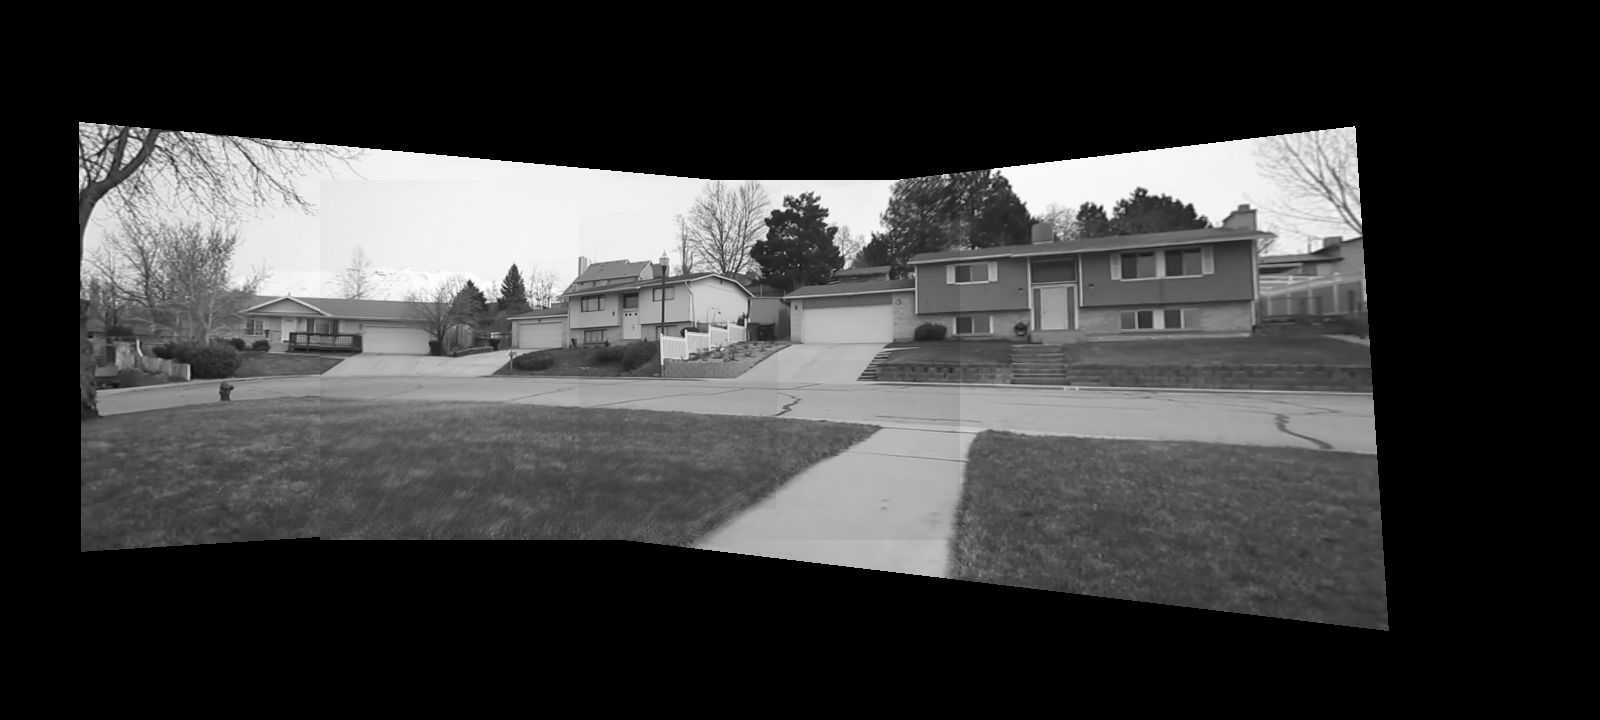

# MOSAICING PERFORMED ON NEW DATASET

In [5]:
g_watsa1 = cv.imread('my_own_dataset/one.jpg',cv.IMREAD_GRAYSCALE)
g_watsa2 = cv.imread('my_own_dataset/two.jpg',cv.IMREAD_GRAYSCALE)
g_watsa3 = cv.imread('my_own_dataset/three.jpg',cv.IMREAD_GRAYSCALE)

In [6]:
g_watsa1.shape

(1280, 960)

In [7]:
image_show([g_watsa1,g_watsa2,g_watsa3],['1','2','3'])

In [8]:
my_own = scipy.io.loadmat('my_own_dataset/my_own.mat')

In [9]:
my_own_corresp1 = my_own['corresp1']
my_own_corresp2 = my_own['corresp2']
my_own_corresp3 = my_own['corresp3']
my_own_corresp4 = my_own['corresp4']

In [10]:
my_own_homography_data21 = HOMOGRAPHY_and_RANSAC(corr_1=my_own_corresp1,corr_2=my_own_corresp2)
my_own_homography_data23 = HOMOGRAPHY_and_RANSAC(corr_1=my_own_corresp4,corr_2=my_own_corresp3)

In [21]:
my_own_homography_data21.RANSAC(required_consensus_fraction=0.8,max_iter=100,consensus_tolerance=10,take_points_from_consensus=True)

my_own_homography_data23.RANSAC(required_consensus_fraction=0.8,max_iter=100,consensus_tolerance=10,take_points_from_consensus=True)

(my_own_C21,my_own_H21,my_own_C_set21) = (my_own_homography_data21.CONSENSUS_FRACTION_g,my_own_homography_data21.HOMOGRAPHY_MATRIX_g,my_own_homography_data21.CONSENSUS_SET_g)
(my_own_C23,my_own_H23,my_own_C_set23) = (my_own_homography_data23.CONSENSUS_FRACTION_g,my_own_homography_data23.HOMOGRAPHY_MATRIX_g,my_own_homography_data23.CONSENSUS_SET_g)

my_own_C21,my_own_C23

(0.8714285714285714, 0.9262295081967213)

In [22]:
len(my_own_C_set21),len(my_own_C_set23)

(61, 113)

In [23]:
my_own_Dout = MOSAIC(image_1=g_watsa1,image_2=g_watsa2,image_3=g_watsa3,H21=my_own_H21,H23=my_own_H23)

In [24]:
image_show([g_watsa1],['adasd'])

In [25]:
my_own_Dout.create_mosaic()

In [43]:
print(my_own_Dout)

OK


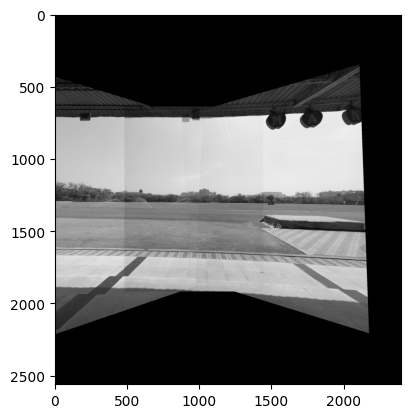

In [27]:
plt.imshow(my_own_Dout.STITCHED_IMAGE,cmap='gray')

In [29]:
cv.imwrite('my_own_dataset/STITCHEDIMAGE.png',my_own_Dout.STITCHED_IMAGE)

True

## Result

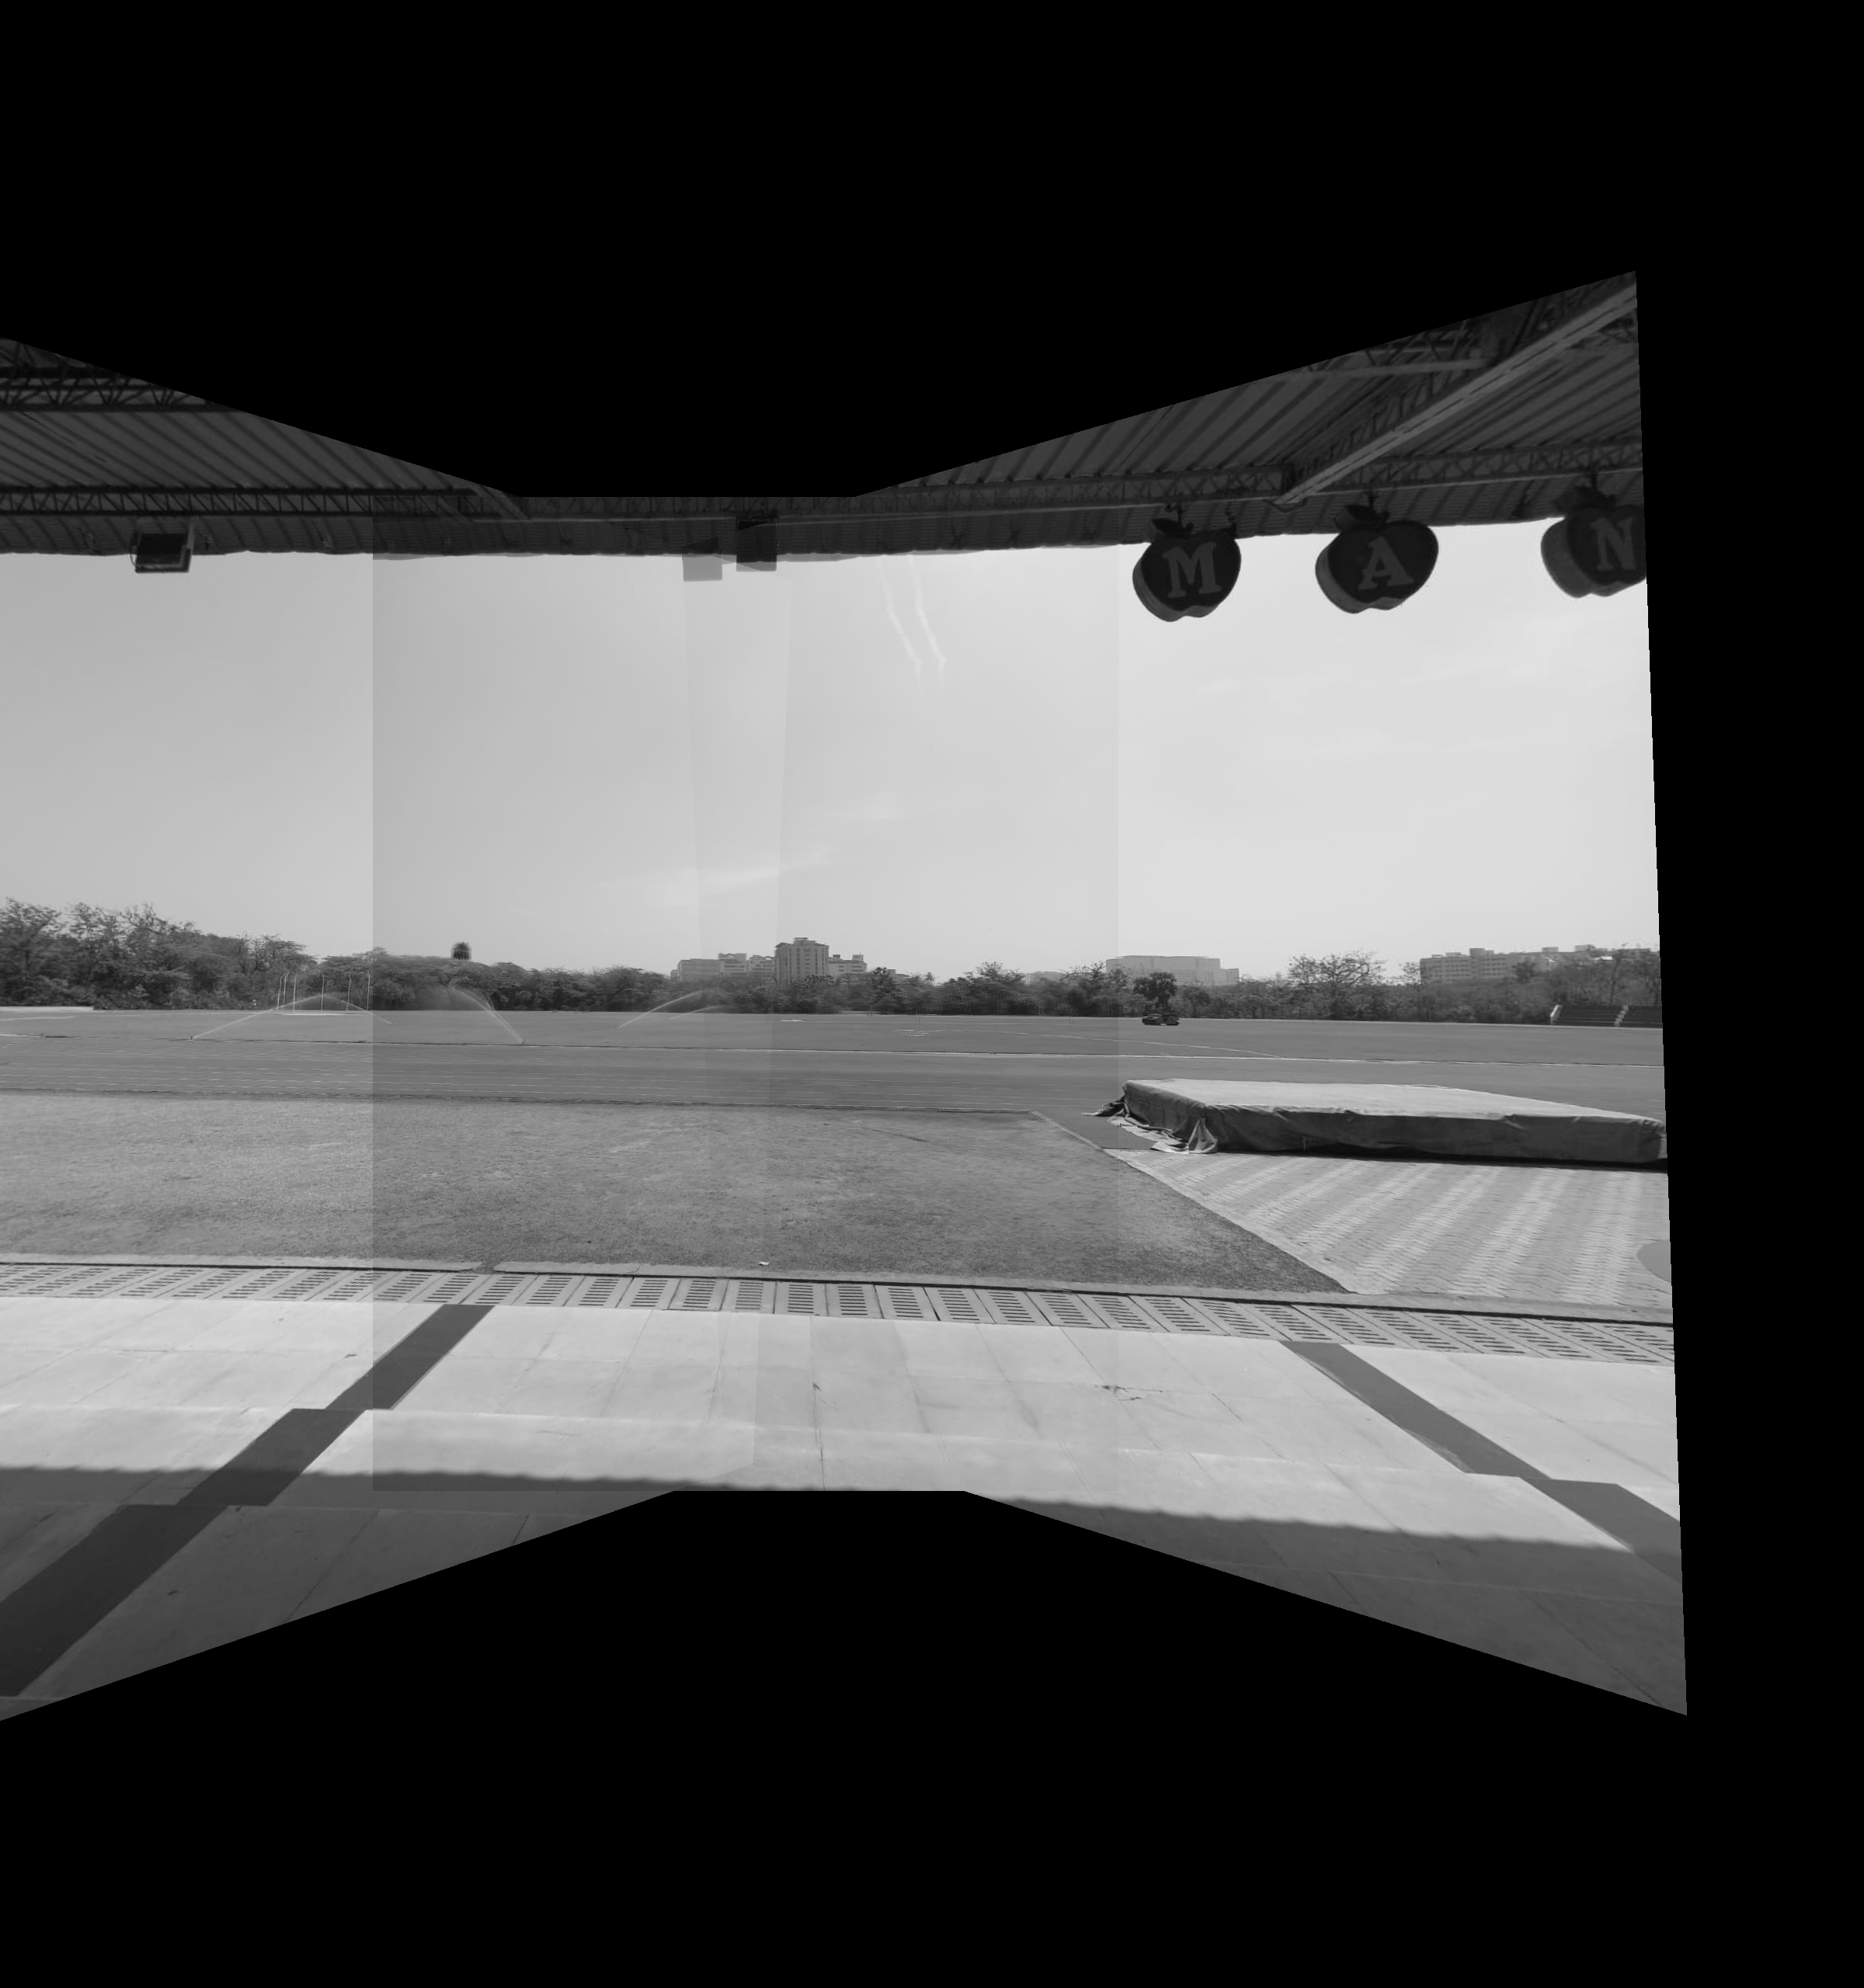